# Classification


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#A-Motivating-Example-Using-sklearn:-Heights-and-Weights" data-toc-modified-id="A-Motivating-Example-Using-sklearn:-Heights-and-Weights-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>A Motivating Example Using <code>sklearn</code>: Heights and Weights</a></span><ul class="toc-item"><li><span><a href="#Checkup-Exercise-Set-I" data-toc-modified-id="Checkup-Exercise-Set-I-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Checkup Exercise Set I</a></span></li><li><span><a href="#Training-and-Test-Datasets" data-toc-modified-id="Training-and-Test-Datasets-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Training and Test Datasets</a></span><ul class="toc-item"><li><span><a href="#Purpose-of-splitting-data-into-Training/testing-sets" data-toc-modified-id="Purpose-of-splitting-data-into-Training/testing-sets-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Purpose of splitting data into Training/testing sets</a></span></li></ul></li><li><span><a href="#Tuning-the-Model" data-toc-modified-id="Tuning-the-Model-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Tuning the Model</a></span></li><li><span><a href="#Checkup-Exercise-Set-II" data-toc-modified-id="Checkup-Exercise-Set-II-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Checkup Exercise Set II</a></span></li><li><span><a href="#Checkup-Exercise-Set-III" data-toc-modified-id="Checkup-Exercise-Set-III-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Checkup Exercise Set III</a></span></li><li><span><a href="#Black-Box-Grid-Search-in-sklearn" data-toc-modified-id="Black-Box-Grid-Search-in-sklearn-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Black Box Grid Search in <code>sklearn</code></a></span></li><li><span><a href="#Checkup-Exercise-Set-IV" data-toc-modified-id="Checkup-Exercise-Set-IV-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Checkup Exercise Set IV</a></span></li></ul></li></ul></div>

**Note:** We've adapted this Mini Project from [Lab 5 in the CS109](https://github.com/cs109/2015lab5) course. Please feel free to check out the original lab, both for more exercises, as well as solutions.

**Code sections answered by the student are preceded by "your turn". Most of the background information on regression was removed.**


In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## A Motivating Example Using `sklearn`: Heights and Weights

We'll use a dataset of heights and weights of males and females to hone our understanding of classifiers. We load the data into a dataframe and plot it.

In [2]:
dflog = pd.read_csv("data/01_heights_weights_genders.csv")
dflog.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<ul>
  <li> <b>Exercise:</b> Create a scatter plot of Weight vs. Height
  <li> <b>Exercise:</b> Color the points differently by Gender
</ul>
</div>

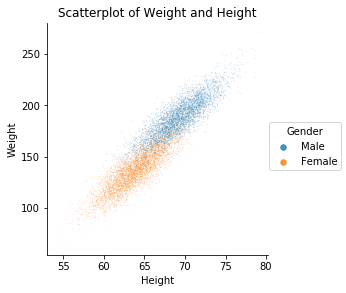

In [3]:
# your turn
p = sns.FacetGrid(dflog, hue='Gender', size=4)
p.map(plt.scatter, 'Height', 'Weight', alpha=.3, s=.03)
p.add_legend()
plt.title('Scatterplot of Weight and Height')

# Make markers in legends bigger and less transparent
for lh in p._legend.legendHandles: 
    lh.set_alpha(.8)
    lh._sizes = [30]

### Training and Test Datasets

When fitting models, we would like to ensure two things:

* We have found the best model (in terms of model parameters).
* The model is highly likely to generalize i.e. perform well on unseen data.

<br/>
<div class="span5 alert alert-success">
<h4>Purpose of splitting data into Training/testing sets</h4>
<ul>
  <li> We built our model with the requirement that the model fit the data well. </li>
  <li> As a side-effect, the model will fit <b>THIS</b> dataset well. What about new data? </li>
    <ul>
      <li> We wanted the model for predictions, right?</li>
    </ul>
  <li> One simple solution, leave out some data (for <b>testing</b>) and <b>train</b> the model on the rest </li>
  <li> This also leads directly to the idea of cross-validation, next section. </li>  
</ul>
</div>

First, we try a basic Logistic Regression:

* Split the data into a training and test (hold-out) set
* Train on the training set, and test for accuracy on the testing set

In [4]:
(dflog.Gender == "Male").values

array([ True,  True,  True, ..., False, False, False])

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score

# Split the data into a training and test set.
Xlr, Xtestlr, ylr, ytestlr = train_test_split(dflog[['Height','Weight']].values, 
                                              (dflog.Gender == "Male").values,random_state=5)

clf = LogisticRegression()
# Fit the model on the trainng data.
clf.fit(Xlr, ylr)
# Print the accuracy from the testing data.
print(accuracy_score(clf.predict(Xtestlr), ytestlr))

0.9252


### Tuning the Model

The model has some hyperparameters we can tune for hopefully better performance. For tuning the parameters of your model, you will use a mix of *cross-validation* and *grid search*. In Logistic Regression, the most important parameter to tune is the *regularization parameter* `C`. Note that the regularization parameter is not always part of the logistic regression model. 

The regularization parameter is used to control for unlikely high regression coefficients, and in other cases can be used when data is sparse, as a method of feature selection.

You will now implement some code to perform model tuning and selecting the regularization parameter $C$.

We use the following `cv_score` function to perform K-fold cross-validation and apply a scoring function to each test fold. In this incarnation we use accuracy score as the default scoring function.

In [6]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

Below is an example of using the `cv_score` function for a basic logistic regression model without regularization.

In [7]:
clf = LogisticRegression()
score = cv_score(clf, Xlr, ylr)
print(score)

0.9170666666666666


<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<b>Exercise:</b> Implement the following search procedure to find a good model
<ul>
<li> You are given a list of possible values of `C` below
<li> For each C:
  <ol>
  <li> Create a logistic regression model with that value of C
  <li> Find the average score for this model using the `cv_score` function **only on the training set** `(Xlr, ylr)`
  </ol>
<li> Pick the C with the highest average score
</ul>
Your goal is to find the best model parameters based *only* on the training set, without showing the model test set at all (which is why the test set is also called a *hold-out* set).
</div>

In [8]:
#the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100]
accuracy = {}

# your turn
for C in Cs:
    clf_c = LogisticRegression(C=C)
    accuracy[C] = cv_score(clf_c, Xlr, ylr)

pd.Series(accuracy)

0.001      0.916933
0.100      0.917067
1.000      0.917067
10.000     0.917067
100.000    0.917067
dtype: float64

For all but the lowest value of C – which corresponds to the strongest regularization – we get the same optimal results. Still, the difference between the model with the lowest C and the rest is minuscule. 

Also, none of the models perform substantially different from the model without regularization. This is because regularization only really makes sense when we have many predictors (relative to the sample size). However, since we have thousands of observations but only two predictors, it is not surprising that regularization doesn't have a detectable effect.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>
**Exercise:** Now you want to estimate how this model will predict on unseen data in the following way:
<ol>
<li> Use the C you obtained from the procedure earlier and train a Logistic Regression on the training data
<li> Calculate the accuracy on the test data
</ol>

<p>You may notice that this particular value of `C` may or may not do as well as simply running the default model on a random train-test split. </p>

<ul>
<li> Do you think that's a problem? 
<li> Why do we need to do this whole cross-validation and grid search stuff anyway?
</ul>

</div>

Since multiple values of C performed equally well, we will just choose one at random. Let's pick 1.

In [9]:
clf_c = (LogisticRegression(C=1) 
            .fit(Xlr, ylr))          
test_accuracy = accuracy_score(ytestlr, 
                               clf_c.predict(Xtestlr))
    
pd.Series(test_accuracy)

0    0.9252
dtype: float64

The accuracy on the test set is slightly higher. While we would expect it to be slightly lower *on average*, we need to remember that the estimates of predictive accuracy that we get through cross-validation are only *point* estimates, and that there is uncertainty attached to them.  We could estimate their standard errors by replicating this procedure with different train-test splits. While we did not do this here, the difference in predictive accuracy between cross-validation on the test set and on the training set are quite small and we can assume that they are not statistically significant.

The reason we need cross-validation is because, if we assessed predictive accuracy on the same data used to estimate the model, we would overestimate our accuracy. Even worse, if we try to maximize predictive accuracy on the test set, we would have an incentive to use overly complex models that fit not just the signal but also the noise. Thus, while they could fit perfectly on the test set, this would not generalize to new data, and the model would thus be useless. Instead, we should try to maximize predictive accuracy on withheld data. Cross-validation is the most efficient way of doing so, because it uses all data points both to fit the model as well as to test it. Thus, it leads to a lower variance of the estimator, compared to using a simple split into test and training set.  

Similarly, we need grid search in order to optimize model parameters where we do not have a theoretical reason that leads us to a priori favor a certain specification. For example, while statistical theory can tell us that some degree of regularization tends to improve predictive accuracy, it cannot tell us what precise strength of the regularization parameters to choose, because this will depend on the data.  Grid search offers us an empirical way of solving this problem.

### Black Box Grid Search in `sklearn`

Scikit-learn, as with many other Python packages, provides utilities to perform common operations so you do not have to do it manually. It is important to understand the mechanics of each operation, but at a certain point, you will want to use the utility instead to save time...

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<b>Exercise:</b> Use scikit-learn's [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html) tool to perform cross validation and grid search. 

* Instead of writing your own loops above to iterate over the model parameters, can you use GridSearchCV to find the best model over the training set? 
* Does it give you the same best value of `C`?
* How does this model you've obtained perform on the test set?</div>

In [10]:
# your turn
Cs = {'C': [0.001, 0.1, 1, 10, 100]}
from sklearn.model_selection import GridSearchCV
lr = LogisticRegression(C=C)
clf_g = GridSearchCV(lr, param_grid=Cs) \
            .fit(Xlr, ylr)
    
pd.DataFrame({'C': (Cs['C']),
             'accuracy': clf_g.cv_results_['mean_test_score']})

,C,accuracy
0,0.001,0.916400
1,0.100,0.917200
2,1.000,0.917333
3,10.000,0.917333
4,100.000,0.917333


Again, all 5 values of C lead to a very similar result. Like when we performed grid search by hand on the same data (the training set), the models with the lowest regularization (highest C) perform marginally better. The only difference is that, for the automatic implementation of grid search, it is the three, not four, highest Cs that lead to the best results. The reason that we don't get the same results in both cases is because the splits into training and test set for cross-validation are likely to be different, so we would not expect the same exact results.

Since we have three equally good values of C, let's choose the middle one – 10 – in order to assess the performance of this model on the test set.

In [11]:
predictions = LogisticRegression(C=10) \
                .fit(Xlr, ylr) \
                .predict(Xtestlr)

accuracy_score(predictions, ytestlr)

0.9252

Again, the accuracy on the test set happens to be slightly higher than the cross-validation accuracy on the training set.  In fact, the accuracy we achieve using sklearn's grid search is the same we achieved implementing grid search ourselves. (This does not necessarily have to be the case, because a different way of splitting the data into the different cross-validation folds could lead to slightly different estimates of predictive accuracy.)